In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from collections import defaultdict
from sklearn.neural_network import MLPRegressor
cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin=0, vmax=8)

In [2]:
df = pd.read_csv('dataset_i5-11gen_74.csv', index_col=False)
df = df.drop(['run-time', 'ref-cycles', 'bus-cycles', 'cpu_clk_unhalted.ref_tsc', 'msr/tsc/', 'cpu-clock', 'cycle_activity.cycles_mem_any','uops_executed.core_cycles_ge_1'], axis=1)
df

,workload,cache-misses,instructions,branches,branch-misses,cycles,faults,cache-references,context-switches,L1-dcache-load-misses,...,IpTB,IpLoad,IpStore,L1D_Cache_Fill_BW,L2_Cache_Fill_BW,L3_Cache_Fill_BW,CPI,MLP,ILP,CPU_Utilization
0,500.perlbench_r,22252122,17848747623,3305557928,31342902,7798519931,46677,143665168,109,81986380,...,10.92,3.63,5.89,2.38,2.45,0.60,0.47,1.38,6.44,0.99
1,500.perlbench_r,43709944,39026539860,7174359822,73051084,16341858764,46798,294049750,148,150810883,...,11.18,3.65,5.72,2.29,2.63,0.59,0.43,1.33,6.77,0.99
2,500.perlbench_r,66635705,60106115818,11017272469,114169765,24837930568,46954,435107640,208,214247524,...,11.26,3.65,5.67,2.26,2.69,0.64,0.42,1.32,6.86,0.99
3,500.perlbench_r,89224958,81130393027,14852875869,155619748,33318284234,47016,575638143,251,278030023,...,11.30,3.65,5.65,2.22,2.70,0.64,0.41,1.32,6.90,0.99
4,500.perlbench_r,112630468,102094289809,18710146889,195925321,41807570879,47147,724640570,302,346942163,...,11.29,3.65,5.65,2.23,2.73,0.64,0.41,1.31,6.92,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,554.roms_r,70760317607,1280839773227,122958282257,162809992,1735104795031,430131,256458144647,2810,130415863049,...,13.66,2.11,9.78,21.76,21.31,11.37,1.25,4.60,4.57,0.99
4826,554.roms_r,71111081487,1286519452651,123484118965,163606447,1743560926156,430131,257766701087,2829,131060188722,...,13.67,2.11,9.78,21.76,21.31,11.37,1.25,4.60,4.57,0.99
4827,554.roms_r,71448309003,1293041754310,124099417947,164506042,1752024260144,430131,258986084022,2849,131681504489,...,13.66,2.11,9.78,21.76,21.30,11.36,1.25,4.60,4.57,0.99
4828,554.roms_r,71786275097,1299505665323,124751537151,165324732,1760481076838,430131,260201847575,2868,132295831541,...,13.67,2.11,9.78,21.76,21.31,11.37,1.25,4.60,4.57,0.99


In [3]:
df = df[['workload', 'cycles', 'cache-misses', 'instructions', 'branches', 'branch-misses',
        'faults', 'cache-references',
       'context-switches', 'L1-dcache-load-misses',
       'L1-dcache-loads', 'L1-dcache-stores', 'L1-icache-load-misses',
       'LLC-load-misses', 'LLC-loads', 'itlb_misses.stlb_hit',
       'LLC-store-misses', 'LLC-stores', 'branch-load-misses', 'branch-loads',
       'mem-stores', 'dTLB-load-misses', 'dTLB-loads', 'dTLB-store-misses',
       'dTLB-stores', 'iTLB-load-misses', 'iTLB-loads',
       'l2_rqsts.all_demand_miss', 'l2_rqsts.all_demand_references',
       'l2_rqsts.code_rd_miss', 'l2_rqsts.demand_data_rd_miss',
       'l2_trans.l2_wb', 'l2_rqsts.miss', 'l2_rqsts.references', 'cycle_activity.stalls_mem_any',
       'cycle_activity.stalls_total', 'uops_executed.stall_cycles',
       'uops_issued.stall_cycles', 'uops_retired.stall_cycles',
       'dtlb_load_misses.stlb_hit', 'dtlb_store_misses.stlb_hit',
       'inst_retired.any', 'br_misp_retired.all_branches',
       'br_inst_retired.all_branches', 'br_inst_retired.near_taken',
       'br_inst_retired.near_call', 'mem_inst_retired.all_loads',
       'mem_inst_retired.all_stores', 'l1d.replacement', 'l2_lines_in.all',
       'longest_lat_cache.miss', 'l1d_pend_miss.pending',
       'l1d_pend_miss.pending_cycles', 'uops_executed.thread', 'IpMispredict', 'BpTkBranch', 'IpBranch', 'IpCall', 'IpTB',
       'IpLoad', 'IpStore', 'L1D_Cache_Fill_BW', 'L2_Cache_Fill_BW',
       'L3_Cache_Fill_BW', 'CPI', 'MLP', 'ILP', 'CPU_Utilization']]
df

,workload,cycles,cache-misses,instructions,branches,branch-misses,faults,cache-references,context-switches,L1-dcache-load-misses,...,IpTB,IpLoad,IpStore,L1D_Cache_Fill_BW,L2_Cache_Fill_BW,L3_Cache_Fill_BW,CPI,MLP,ILP,CPU_Utilization
0,500.perlbench_r,7798519931,22252122,17848747623,3305557928,31342902,46677,143665168,109,81986380,...,10.92,3.63,5.89,2.38,2.45,0.60,0.47,1.38,6.44,0.99
1,500.perlbench_r,16341858764,43709944,39026539860,7174359822,73051084,46798,294049750,148,150810883,...,11.18,3.65,5.72,2.29,2.63,0.59,0.43,1.33,6.77,0.99
2,500.perlbench_r,24837930568,66635705,60106115818,11017272469,114169765,46954,435107640,208,214247524,...,11.26,3.65,5.67,2.26,2.69,0.64,0.42,1.32,6.86,0.99
3,500.perlbench_r,33318284234,89224958,81130393027,14852875869,155619748,47016,575638143,251,278030023,...,11.30,3.65,5.65,2.22,2.70,0.64,0.41,1.32,6.90,0.99
4,500.perlbench_r,41807570879,112630468,102094289809,18710146889,195925321,47147,724640570,302,346942163,...,11.29,3.65,5.65,2.23,2.73,0.64,0.41,1.31,6.92,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,554.roms_r,1735104795031,70760317607,1280839773227,122958282257,162809992,430131,256458144647,2810,130415863049,...,13.66,2.11,9.78,21.76,21.31,11.37,1.25,4.60,4.57,0.99
4826,554.roms_r,1743560926156,71111081487,1286519452651,123484118965,163606447,430131,257766701087,2829,131060188722,...,13.67,2.11,9.78,21.76,21.31,11.37,1.25,4.60,4.57,0.99
4827,554.roms_r,1752024260144,71448309003,1293041754310,124099417947,164506042,430131,258986084022,2849,131681504489,...,13.66,2.11,9.78,21.76,21.30,11.36,1.25,4.60,4.57,0.99
4828,554.roms_r,1760481076838,71786275097,1299505665323,124751537151,165324732,430131,260201847575,2868,132295831541,...,13.67,2.11,9.78,21.76,21.31,11.37,1.25,4.60,4.57,0.99


In [4]:
# Separating features and target into numpy arrays

X=np.array(df.loc[:, 'cache-misses':]).reshape(-1, df.shape[1]-2)
y=np.array(df['cycles']).reshape(-1, 1)

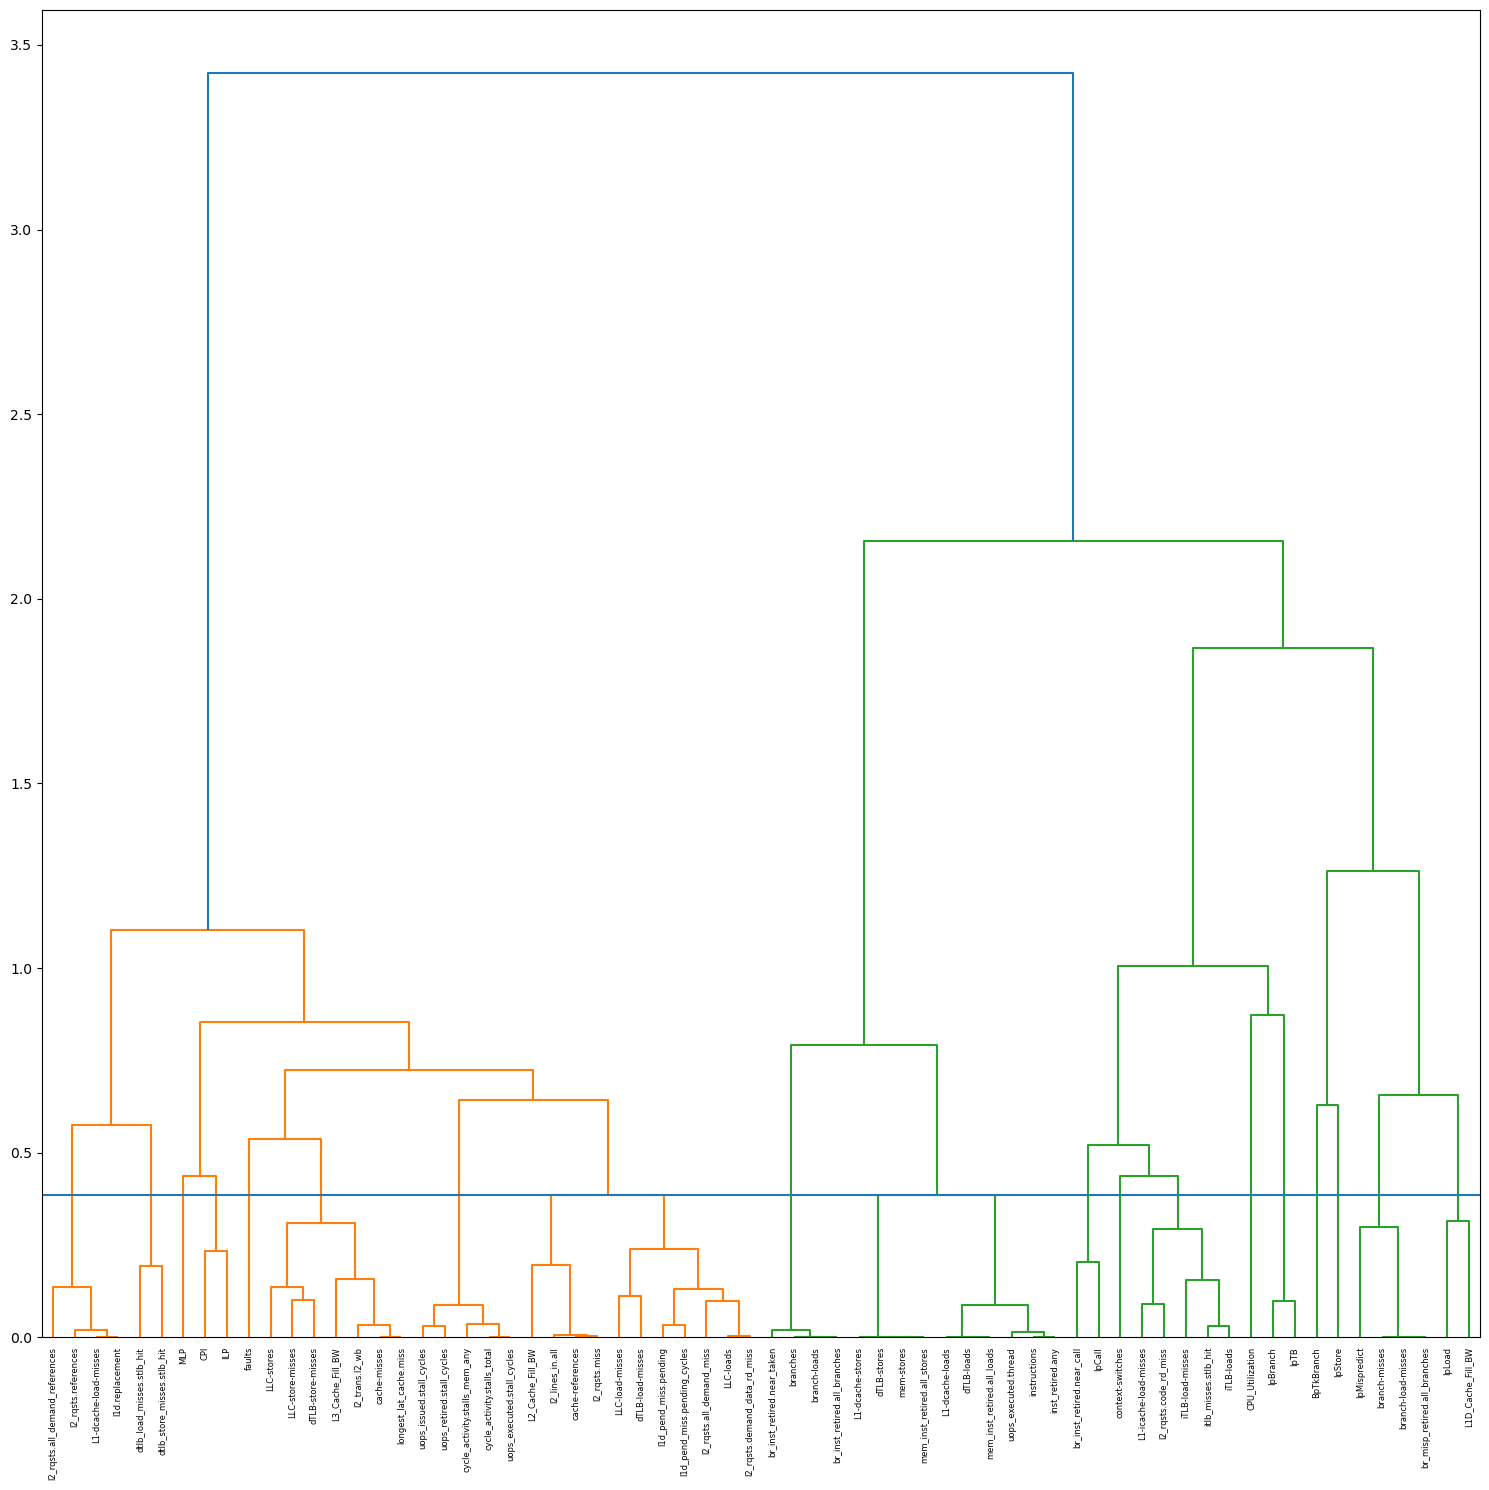

In [5]:
# Spearman correlation between features and clustering similar features
num_clusters = 20

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(dist_linkage, labels=df.columns[2:], ax=ax, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro["ivl"]))
plt.axhline((dist_linkage[-num_clusters, 2]+dist_linkage[-num_clusters+1, 2])/2)
fig.tight_layout()
plt.show()

In [6]:
cluster_ids = hierarchy.fcluster(dist_linkage, num_clusters, criterion="maxclust")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

In [7]:
min_cor=2
for c in cluster_id_to_feature_ids.values():
    for i in c:
        for j in c:
            if min_cor>abs(df.iloc[:, i+2].corr(df.iloc[:, j+2], 'spearman')):
                min_cor, icol, jcol=abs(df.iloc[:,i+2].corr(df.iloc[:,j+2], 'spearman')), i, j
print('Minimum correlation among same cluster points:', min_cor, icol, jcol)

0.6643942641981171 19 60


In [8]:
df.columns[icol+2], df.columns[jcol+2]

('dTLB-load-misses', 'L2_Cache_Fill_BW')

In [9]:
len(cluster_id_to_feature_ids.keys())

20

In [11]:
# performance counters in each clusters
cluster_df = pd.DataFrame([[df.columns[j+2] for j in cluster_id_to_feature_ids[i]] for i in cluster_id_to_feature_ids.keys()]).T
cluster_df = cluster_df[cluster_df.isna().sum().sort_values().index].replace(np. nan,'',regex=True)
cluster_df

,5,0,1,10,9,3,7,8,2,11,12,14,15,17,6,18,13,16,4,19
0,cache-references,cache-misses,instructions,cycle_activity.stalls_mem_any,L1-icache-load-misses,branch-misses,L1-dcache-load-misses,L1-dcache-stores,branches,dtlb_load_misses.stlb_hit,br_inst_retired.near_call,IpBranch,IpLoad,CPI,context-switches,MLP,BpTkBranch,IpStore,faults,CPU_Utilization
1,LLC-load-misses,LLC-store-misses,L1-dcache-loads,cycle_activity.stalls_total,itlb_misses.stlb_hit,branch-load-misses,l2_rqsts.all_demand_references,mem-stores,branch-loads,dtlb_store_misses.stlb_hit,IpCall,IpTB,L1D_Cache_Fill_BW,ILP,,,,,,
2,LLC-loads,LLC-stores,dTLB-loads,uops_executed.stall_cycles,iTLB-load-misses,br_misp_retired.all_branches,l2_rqsts.references,dTLB-stores,br_inst_retired.all_branches,,,,,,,,,,,
3,dTLB-load-misses,dTLB-store-misses,inst_retired.any,uops_issued.stall_cycles,iTLB-loads,IpMispredict,l1d.replacement,mem_inst_retired.all_stores,br_inst_retired.near_taken,,,,,,,,,,,
4,l2_rqsts.all_demand_miss,l2_trans.l2_wb,mem_inst_retired.all_loads,uops_retired.stall_cycles,l2_rqsts.code_rd_miss,,,,,,,,,,,,,,,
5,l2_rqsts.demand_data_rd_miss,longest_lat_cache.miss,uops_executed.thread,,,,,,,,,,,,,,,,,
6,l2_rqsts.miss,L3_Cache_Fill_BW,,,,,,,,,,,,,,,,,,
7,l2_lines_in.all,,,,,,,,,,,,,,,,,,,
8,l1d_pend_miss.pending,,,,,,,,,,,,,,,,,,,
9,l1d_pend_miss.pending_cycles,,,,,,,,,,,,,,,,,,,


In [12]:
models = ['LR', 'DT', 'RF', 'XGB', 'KNN', 'MLP']
estimator = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), XGBRegressor(), KNeighborsRegressor(), MLPRegressor(max_iter=300)]

In [13]:
workloads={"500.perlbench_r":0,
		"502.gcc_r":1,
		"505.mcf_r":2,
		"520.omnetpp_r":3,
		"523.xalancmbk_r":4,
		"525.x264_r":5,
		"531.deepsjeng_r":6,
		"541.leela_r":7,
		"548.exchange2_r":8,
		"557.xz_r":9,
		"503.bwaves_r":10,
		"507.cactuBSSN_r":11,
		"508.namd_r":12,
		"510.parest_r":13,
		"511.povray_r":14,
		"519.lbm_r":15,
		"521.wrf_r":16,
		"526.blender_r":17,
		"527.cam4_r":18,
		"538.imagick_r":19,
		"544.nab_r":20,
		"549.fotonik3d_r":21,
		"554.roms_r":22}
df['wkld']=df['workload']
df=pd.get_dummies(df, columns=['wkld'])
df['workload']=df['workload'].astype('category').map(workloads)
df

C:\Users\HP\AppData\Local\Temp\ipykernel_10484\4239537774.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wkld']=df['workload']


,workload,cycles,cache-misses,instructions,branches,branch-misses,faults,cache-references,context-switches,L1-dcache-load-misses,...,wkld_526.blender_r,wkld_527.cam4_r,wkld_531.deepsjeng_r,wkld_538.imagick_r,wkld_541.leela_r,wkld_544.nab_r,wkld_548.exchange2_r,wkld_549.fotonik3d_r,wkld_554.roms_r,wkld_557.xz_r
0,0,7798519931,22252122,17848747623,3305557928,31342902,46677,143665168,109,81986380,...,0,0,0,0,0,0,0,0,0,0
1,0,16341858764,43709944,39026539860,7174359822,73051084,46798,294049750,148,150810883,...,0,0,0,0,0,0,0,0,0,0
2,0,24837930568,66635705,60106115818,11017272469,114169765,46954,435107640,208,214247524,...,0,0,0,0,0,0,0,0,0,0
3,0,33318284234,89224958,81130393027,14852875869,155619748,47016,575638143,251,278030023,...,0,0,0,0,0,0,0,0,0,0
4,0,41807570879,112630468,102094289809,18710146889,195925321,47147,724640570,302,346942163,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,22,1735104795031,70760317607,1280839773227,122958282257,162809992,430131,256458144647,2810,130415863049,...,0,0,0,0,0,0,0,0,1,0
4826,22,1743560926156,71111081487,1286519452651,123484118965,163606447,430131,257766701087,2829,131060188722,...,0,0,0,0,0,0,0,0,1,0
4827,22,1752024260144,71448309003,1293041754310,124099417947,164506042,430131,258986084022,2849,131681504489,...,0,0,0,0,0,0,0,0,1,0
4828,22,1760481076838,71786275097,1299505665323,124751537151,165324732,430131,260201847575,2868,132295831541,...,0,0,0,0,0,0,0,0,1,0


In [14]:
col_names = list(df.iloc[:, 2:-23])
X=np.array(df.drop(['cycles', 'workload'], axis=1)).reshape(-1, df.shape[1]-2)
y=np.array(df['cycles']).reshape(-1, 1)
X, y = StandardScaler().fit_transform(X), StandardScaler().fit_transform(y)

In [15]:
feature_rankings = pd.DataFrame(index=col_names, columns=models)
e = estimator[0].fit(X, y)
feature_rankings['LR']=pd.Series(pd.Series(e.coef_[0][:-23]).sort_values(key=lambda x: abs(x)).index).sort_values().index
#display_hbar(lin_reg_coef, 'Linear regression coefficients')
for model in range(1, 4):
    e = estimator[model].fit(X, y)
    feature_rankings[models[model]]=pd.Series(pd.Series(e.feature_importances_[:-23]).sort_values(key=lambda x: abs(x)).index).sort_values().index
for model in range(4, 6):
    e = estimator[model].fit(X, y)
    results = permutation_importance(e, X, y, scoring='neg_mean_squared_error')
    feature_rankings[models[model]]=pd.Series(pd.Series(results.importances_mean[:-23]).sort_values(key=lambda x: abs(x)).index).sort_values().index

C:\Users\HP\AppData\Local\Temp\ipykernel_10484\626196128.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  e = estimator[model].fit(X, y)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
feature_rankings

,LR,DT,RF,XGB,KNN,MLP
cache-misses,54,4,5,17,37,55
instructions,41,62,62,61,60,20
branches,39,44,46,36,42,33
branch-misses,26,30,44,44,65,47
faults,38,3,18,21,36,30
...,...,...,...,...,...,...
L3_Cache_Fill_BW,12,13,12,24,6,44
CPI,7,1,1,11,9,42
MLP,17,2,6,38,8,3
ILP,18,7,26,3,3,28


In [51]:
selected_features = pd.DataFrame(index=range(20), columns=models)
for model in range(len(models)):
    selected_features[models[model]]=pd.Series([cluster_id_to_feature_ids[j][np.argmax([feature_rankings.iloc[i,model] for i in cluster_id_to_feature_ids[j]])] for j in range(1, num_clusters+1)]).sort_values(key=lambda x: -feature_rankings.iloc[x,model], ignore_index=True)
selected_features.applymap(lambda x: col_names[x])

,LR,DT,RF,XGB,KNN,MLP
0,uops_executed.stall_cycles,uops_executed.thread,uops_executed.thread,uops_executed.thread,branch-misses,cycle_activity.stalls_total
1,l1d.replacement,uops_retired.stall_cycles,uops_retired.stall_cycles,context-switches,uops_executed.thread,mem_inst_retired.all_loads
2,mem-stores,context-switches,context-switches,uops_retired.stall_cycles,dTLB-load-misses,mem-stores
3,branch-loads,LLC-loads,iTLB-load-misses,dtlb_store_misses.stlb_hit,uops_retired.stall_cycles,longest_lat_cache.miss
4,uops_executed.thread,iTLB-load-misses,LLC-loads,branch-load-misses,IpStore,cache-references
5,cache-misses,L1-dcache-stores,br_misp_retired.all_branches,LLC-loads,IpCall,dtlb_load_misses.stlb_hit
6,LLC-loads,branch-loads,L1-dcache-stores,itlb_misses.stlb_hit,LLC-store-misses,br_misp_retired.all_branches
7,iTLB-loads,dtlb_store_misses.stlb_hit,branches,IpBranch,br_inst_retired.near_taken,br_inst_retired.near_call
8,faults,BpTkBranch,longest_lat_cache.miss,L1-dcache-load-misses,dTLB-stores,IpLoad
9,branch-load-misses,IpCall,dtlb_store_misses.stlb_hit,branch-loads,faults,itlb_misses.stlb_hit


In [58]:
selected_features.applymap(lambda x: col_names[x]).to_csv('selected_features.csv')

In [20]:
#select top ranking feature from each cluster
X=np.array([df.iloc[:, [i+2 for i in selected_features.iloc[:,j]]] for j in range(len(models))])
y=np.array(df['cycles']).reshape(-1, 1)

In [26]:
lo, hi, jmp = 10, 501, 10             # training size range
iters = (hi-lo-1)//jmp + 1
score = np.zeros((iters, len(models), num_clusters))
mae = np.zeros((iters, len(models), num_clusters))
mse = np.zeros((iters, len(models), num_clusters))
indices = np.arange(X.shape[1])
if lo!=jmp:
    train_idx, test_idx = train_test_split(indices, train_size=lo)
else: 
    train_idx, test_idx = np.zeros((0), dtype=np.int32), indices
for trs in range(iters):
    trainpool_idx, test_idx = train_test_split(test_idx, train_size=jmp)
    train_idx = np.concatenate((train_idx, trainpool_idx))
    y_scaler = StandardScaler().fit(y[train_idx])
    y_train, y_test = y_scaler.transform(y[train_idx]), y_scaler.transform(y[test_idx])
    print(len(train_idx), len(test_idx))
    for model in range(len(models)):
        X_scaler = StandardScaler().fit(X[model][train_idx])
        X_train, X_test = X_scaler.transform(X[model][train_idx]), X_scaler.transform(X[model][test_idx])
        X_train = np.concatenate((X_train, df.iloc[train_idx, -23:]), axis=1)
        X_test = np.concatenate((X_test, df.iloc[test_idx, -23:]), axis=1)
        for num_features in range(0, num_clusters, 5):
            e = estimator[model].fit(X_train[:, :24+num_features], y_train.ravel())     #include one-hot encoded workload columns + first num_features features only
            score[trs][model][num_features] = e.score(X_test[:, :24+num_features], y_test)
            y_pred = e.predict(X_test[:, :24+num_features])
            mae[trs][model][num_features] = mean_absolute_error(y_true=y_test, y_pred=y_pred)
            mse[trs][model][num_features] = mean_squared_error(y_true=y_test, y_pred=y_pred)

10 4820
20 4810
30 4800
40 4790
50 4780
60 4770
70 4760
80 4750
90 4740
100 4730
110 4720
120 4710
130 4700
140 4690
150 4680
160 4670
170 4660
180 4650
190 4640
200 4630
210 4620
220 4610
230 4600
240 4590
250 4580
260 4570
270 4560
280 4550
290 4540
300 4530
310 4520
320 4510
330 4500
340 4490
350 4480
360 4470
370 4460
380 4450
390 4440
400 4430
410 4420
420 4410
430 4400
440 4390
450 4380
460 4370
470 4360
480 4350
490 4340
500 4330


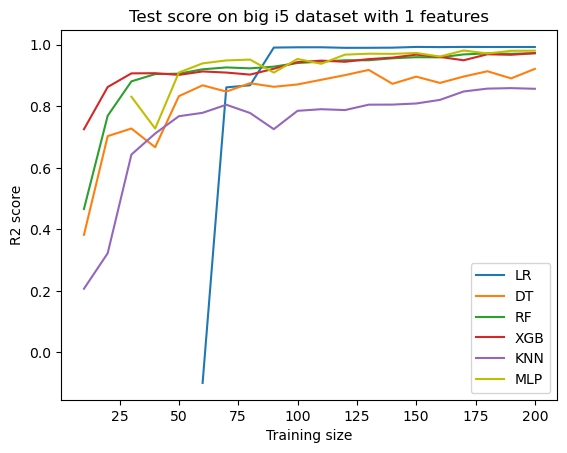

In [77]:
l=10
h=201
f=1
plt.plot(range(60, h, jmp), score[60//10-1:h//10, 0, f-1], label=models[0])
for model in range(1,5):
    plt.plot(range(l, h, jmp), score[l//10-1:h//10, model, f-1], label=models[model])
plt.plot(range(30, h, jmp), score[30//10-1:h//10, 5, f-1], label=models[5], color='y')
plt.legend()
plt.title('Test score on big i5 dataset with '+str(f)+' features')
plt.xlabel('Training size')
plt.ylabel('R2 score')
plt.show()

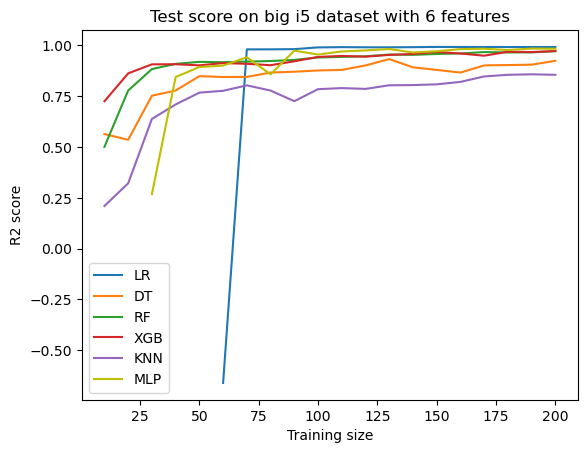

In [78]:
l=10
h=201
f=6
plt.plot(range(60, h, jmp), score[60//10-1:h//10, 0, f-1], label=models[0])
for model in range(1,5):
    plt.plot(range(l, h, jmp), score[l//10-1:h//10, model, f-1], label=models[model])
plt.plot(range(30, h, jmp), score[30//10-1:h//10, 5, f-1], label=models[5], color='y')
plt.legend()
plt.title('Test score on big i5 dataset with '+str(f)+' features')
plt.xlabel('Training size')
plt.ylabel('R2 score')
plt.show()

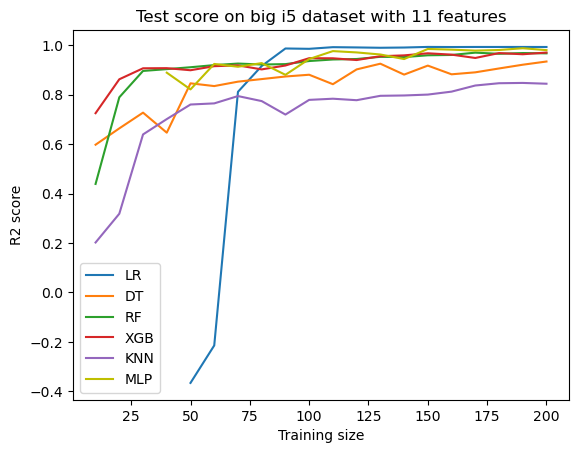

In [72]:
l=10
h=201
f=11
plt.plot(range(50, h, jmp), score[50//10-1:h//10, 0, f-1], label=models[0])
for model in range(1,5):
    plt.plot(range(l, h, jmp), score[l//10-1:h//10, model, f-1], label=models[model])
plt.plot(range(40, h, jmp), score[40//10-1:h//10, 5, f-1], label=models[5], color='y')
plt.legend()
plt.title('Test score on big i5 dataset with '+str(f)+' features')
plt.xlabel('Training size')
plt.ylabel('R2 score')
plt.show()

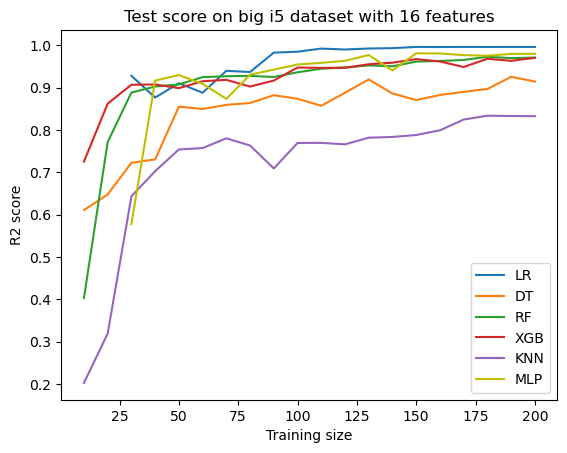

In [75]:
l=10
h=201
f=16
plt.plot(range(30, h, jmp), score[30//10-1:h//10, 0, f-1], label=models[0])
for model in range(1,5):
    plt.plot(range(l, h, jmp), score[l//10-1:h//10, model, f-1], label=models[model])
plt.plot(range(30, h, jmp), score[30//10-1:h//10, 5, f-1], label=models[5], color='y')
plt.legend()
plt.title('Test score on big i5 dataset with '+str(f)+' features')
plt.xlabel('Training size')
plt.ylabel('R2 score')
plt.show()

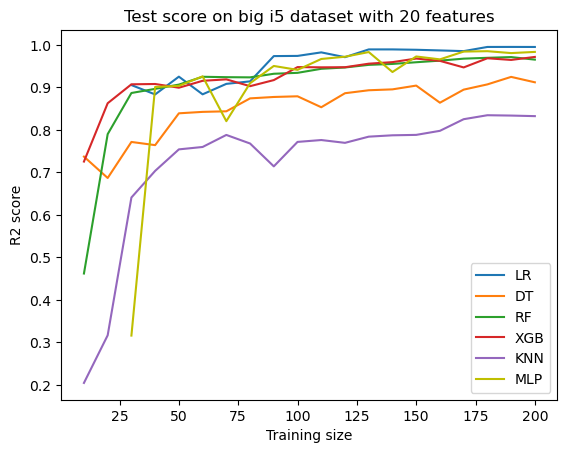

In [62]:
l=10
h=201
f=20
plt.plot(range(30, h, jmp), score[30//10-1:h//10, 0, f-1], label=models[0])
for model in range(1,5):
    plt.plot(range(l, h, jmp), score[l//10-1:h//10, model, f-1], label=models[model])
plt.plot(range(30, h, jmp), score[30//10-1:h//10, 5, f-1], label=models[5], color='y')
plt.legend()
plt.title('Test score on big i5 dataset with '+str(f)+' features')
plt.xlabel('Training size')
plt.ylabel('R2 score')
plt.show()

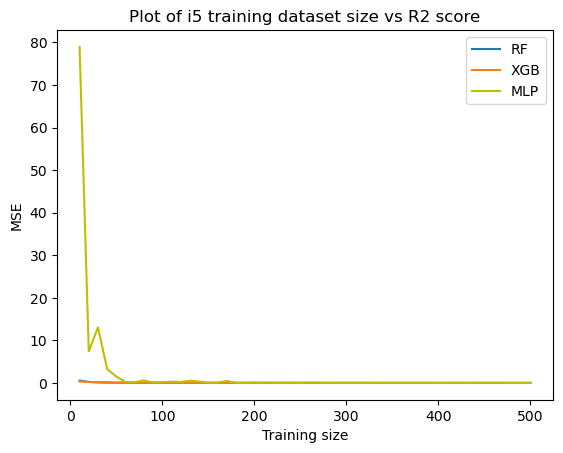

In [299]:
l=10
#plt.plot(range(l, hi, jmp), mse[l//10-1:, 0], label=models[0])
for model in range(2, 4):
    plt.plot(range(l, hi, jmp), mse[l//10-1:, model], label=models[model])
plt.plot(range(l, hi, jmp), mse[l//10-1:, 5], label=models[5], color='y')
plt.legend()
plt.title('Plot of i5 training dataset size vs R2 score')
plt.xlabel('Training size')
plt.ylabel('MSE')
plt.show()

In [79]:
pd.DataFrame(score[:10,5], range(lo, 101, jmp))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
10,-154.545195,0.0,0.0,0.0,0.0,-79.049487,0.0,0.0,0.0,0.0,-202.364928,0.0,0.0,0.0,0.0,-594.137220,0.0,0.0,0.0,-9.790961
20,-4.348391,0.0,0.0,0.0,0.0,-612.616224,0.0,0.0,0.0,0.0,-5.876444,0.0,0.0,0.0,0.0,-803.279302,0.0,0.0,0.0,-504.006171
30,0.830986,0.0,0.0,0.0,0.0,0.268272,0.0,0.0,0.0,0.0,-2.117008,0.0,0.0,0.0,0.0,0.577649,0.0,0.0,0.0,0.315824
40,0.727622,0.0,0.0,0.0,0.0,0.844442,0.0,0.0,0.0,0.0,0.889245,0.0,0.0,0.0,0.0,0.916996,0.0,0.0,0.0,0.900854
50,0.909675,0.0,0.0,0.0,0.0,0.893744,0.0,0.0,0.0,0.0,0.821582,0.0,0.0,0.0,0.0,0.930077,0.0,0.0,0.0,0.903401
60,0.939473,0.0,0.0,0.0,0.0,0.900849,0.0,0.0,0.0,0.0,0.924536,0.0,0.0,0.0,0.0,0.909245,0.0,0.0,0.0,0.925810
70,0.949035,0.0,0.0,0.0,0.0,0.941809,0.0,0.0,0.0,0.0,0.913208,0.0,0.0,0.0,0.0,0.873697,0.0,0.0,0.0,0.820339
80,0.951720,0.0,0.0,0.0,0.0,0.857694,0.0,0.0,0.0,0.0,0.927967,0.0,0.0,0.0,0.0,0.930939,0.0,0.0,0.0,0.909676
90,0.909508,0.0,0.0,0.0,0.0,0.974250,0.0,0.0,0.0,0.0,0.880538,0.0,0.0,0.0,0.0,0.942923,0.0,0.0,0.0,0.950255
100,0.953720,0.0,0.0,0.0,0.0,0.955268,0.0,0.0,0.0,0.0,0.944380,0.0,0.0,0.0,0.0,0.954955,0.0,0.0,0.0,0.941084


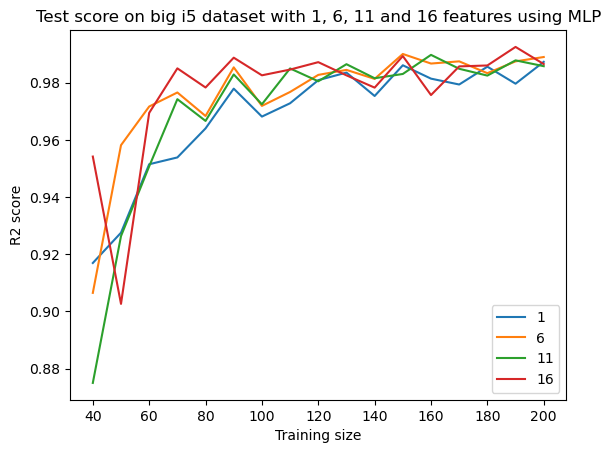

In [50]:
l=40
h=201
for num_features in range(0,num_clusters,5):
    plt.plot(range(l, h, jmp), score[l//10-1:h//10, 5, num_features], label=num_features+1)
plt.legend()
plt.title('Test score on big i5 dataset with 1, 6, 11 and 16 features using MLP')
plt.xlabel('Training size')
plt.ylabel('R2 score')
plt.show()